In [1]:
import sys
import os
sys.path.append('/usr0/home/drschwar/src/bert_brain/')
from collections import OrderedDict
from functools import partial

from tqdm.auto import trange, tqdm

import numpy as np

from bert_brain_paths import Paths
from bert_brain import get_mask_for_subject, named_variations, task_hash, match_variation, TrainingVariation, \
    LoadFrom, sentence_predictions, query_results, ResultQuery, fdr_correction, ResultPValues, get_k_vs_k_paired, \
    get_mse_paired
%matplotlib inline
from matplotlib import pyplot as plt

import cortex

def make_volume(data, subject, mask=None, **kwargs):
    if mask is None:
        mask = get_mask_for_subject(subject)
    if subject in ['H', 'K', 'L']:
        xfmname = '{}_ars_auto2'.format(subject)
    else:
        xfmname = '{}_ars'.format(subject)
    return cortex.Volume(data, 'fMRI_story_{}'.format(subject), xfmname, mask=mask, **kwargs)

paths = Paths()

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [11]:
result_queries = list()
subjects = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']    

"""
Note: the variation-set names are a little confusing below. They are a legacy of some earlier experiments.
The labels are better descriptors of what these are actually comparing. The left-side of the label 
(i.e. before the vs.) describes variation a, and the right side describes variation b

Reading the outputs and doing the computations takes a little while, so we picke the results, and then unpickle
for plotting.
"""

# Joint everything vs. linear vanilla
# label = 'joint_everything_vs_vanilla'
# variation_set_name_a = 'hp_fmri_meg_joint'
# fmri_subjects_ = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
# fmri_tasks_ = tuple('hp_fmri_{}'.format(s) for s in fmri_subjects_)
# training_variation_a_fmt = str(fmri_tasks_ + ('hp_meg',))
# variation_set_name_b = 'hp_meg_simple_fmri_linear'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# fine-tuned vs. linear vanilla
# label = 'fine_tuned_vs_vanilla'
# variation_set_name_a = 'hp_meg_simple_fmri'
# training_variation_a_fmt = '(\'hp_fmri_{subject}\',)'
# variation_set_name_b = 'hp_HKL_from_I'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# Linear from I vs. linear vanilla:
# label = 'from_I_vs_vanilla'
# variation_set_name_a = 'hp_HKL_from_I'
# training_variation_a_fmt = '(\'hp_fmri_{subject}\',).hp_fmri_20:(\'hp_fmri_I\',)'
# variation_set_name_b = 'hp_HKL_from_I'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# MEG to fMRI vs. fMRI
label = 'MEG_to_fMRI_vs_fMRI'
variation_set_name_a = 'hp_meg_simple_fmri'
training_variation_a_fmt = '(\'hp_fmri_{subject}\',).hp_meg:(\'hp_meg\',)'
variation_set_name_b = 'hp_meg_simple_fmri'
training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# MEG to fMRI vs. vanilla
# label = 'MEG_to_fMRI_vs_vanilla'
# variation_set_name_a = 'hp_meg_simple_fmri'
# training_variation_a_fmt = '(\'hp_fmri_{subject}\',).hp_fmri_meg:(\'hp_meg\',)'
# variation_set_name_b = 'hp_meg_simple_fmri_linear'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'
        
# results = list()

# for idx_subject, subject in enumerate(tqdm(subjects)):
#     a_accuracy, b_accuracy = get_k_vs_k_paired(
#         paths,
#         variation_set_name_a, 
#         training_variation_a_fmt.format(subject=subject), 
#         variation_set_name_b, 
#         training_variation_b_fmt.format(subject=subject), 
#         'hp_fmri_{}'.format(subject),
#         k=20, 
#         num_samples=1000,
#         mean_within_run=True)
    
#     results.append(ResultPValues(label, subject, a_accuracy, b_accuracy))

results = list()

for idx_subject, subject in enumerate(tqdm(subjects)):
    mse_a, pove_a, mse_b, pove_b = get_mse_paired(
        paths,
        variation_set_name_a,
        training_variation_a_fmt.format(subject=subject), 
        variation_set_name_b, 
        training_variation_b_fmt.format(subject=subject), 
        'hp_fmri_{}'.format(subject))
    
    results.append(ResultPValues(label, subject, pove_a, pove_b))

import pickle
with open('pove_plot_info_{}.bin'.format(label), 'wb') as f:
    pickle.dump(results, f)

In [12]:
label = 'MEG_to_fMRI_vs_fMRI'
# label = 'from_I_vs_vanilla'
# label = 'fine_tuned_vs_vanilla'
# label = 'joint_everything_vs_vanilla'
import pickle
with open('pove_plot_info_{}.bin'.format(label), 'rb') as f:
    result = pickle.load(f)

In [4]:
# brain plots of a single training procedure (not a comparison), using a one-sample t-test mask
def add_single(volume_dict, label, subject, means, p_values=None):
    if p_values is not None:
        mask, _ = fdr_correction(p_values, alpha=0.01, method='bh')
        means = np.where(mask, means, np.nan)
    vmin = np.nanquantile(means, 0.05) 
    vmax = np.nanquantile(means, 0.95)
    volume_dict['{}:{}'.format(label, subject)] = make_volume(means, subject, cmap='viridis', vmin=vmin, vmax=vmax)
    volume_dict['{}:{}, stat-sig'.format(label, subject)] = make_volume(mask, subject, cmap='viridis')

volume_dict = dict()
for r in result:
    a_label, b_label = r.label.split('_vs_')
    add_single(volume_dict, a_label, r.subject, r.a_mean, r.a_ttest_1samp_p_values)
    add_single(volume_dict, b_label, r.subject, r.b_mean, r.b_ttest_1samp_p_values)
    
cortex.webshow(volume_dict, open_browser=False)

Started server on port 5300


<WebApp(Thread-4, started 140496081680128)>

Stopping server


In [7]:
def add_pair(volume_dict, label, subject, a_means, b_means, p_values=None, add_indiv=True):
    if p_values is not None:
        mask, _ = fdr_correction(p_values, alpha=0.01, method='bh')
        a_means = np.where(mask, a_means, np.nan)
        b_means = np.where(mask, b_means, np.nan)
    if add_indiv:
        vmin = min(np.nanquantile(a_means, 0.05), np.nanquantile(b_means, 0.05))
        vmax = max(np.nanquantile(a_means, 0.95), np.nanquantile(b_means, 0.95))
        volume_dict['{}:{}, a'.format(label, subject)] = make_volume(
            a_means, subject, cmap='viridis', vmin=vmin, vmax=vmax)
        volume_dict['{}:{}, b'.format(label, subject)] = make_volume(
            b_means, subject, cmap='viridis', vmin=vmin, vmax=vmax)
    volume_dict['{}:{}, stat-sig'.format(label, subject)] = make_volume(mask, subject, cmap='viridis')
    masked_diff = np.where(mask, a_means - b_means, np.nan)
    vmax = np.nanquantile(np.abs(masked_diff), 0.95)
    vmin = -vmax
    volume_dict['{}:{}, difference'.format(label, subject)] = make_volume(
        masked_diff, subject, cmap='bwr', vmin=vmin, vmax=vmax)

volume_dict = dict()
for r in result:
    add_pair(volume_dict, r.label, r.subject, r.a_mean, r.b_mean, r.ttest_rel_p_values)
cortex.webshow(volume_dict, open_browser=False)


Started server on port 42566


<WebApp(Thread-5, started 140496081680128)>

Stopping server


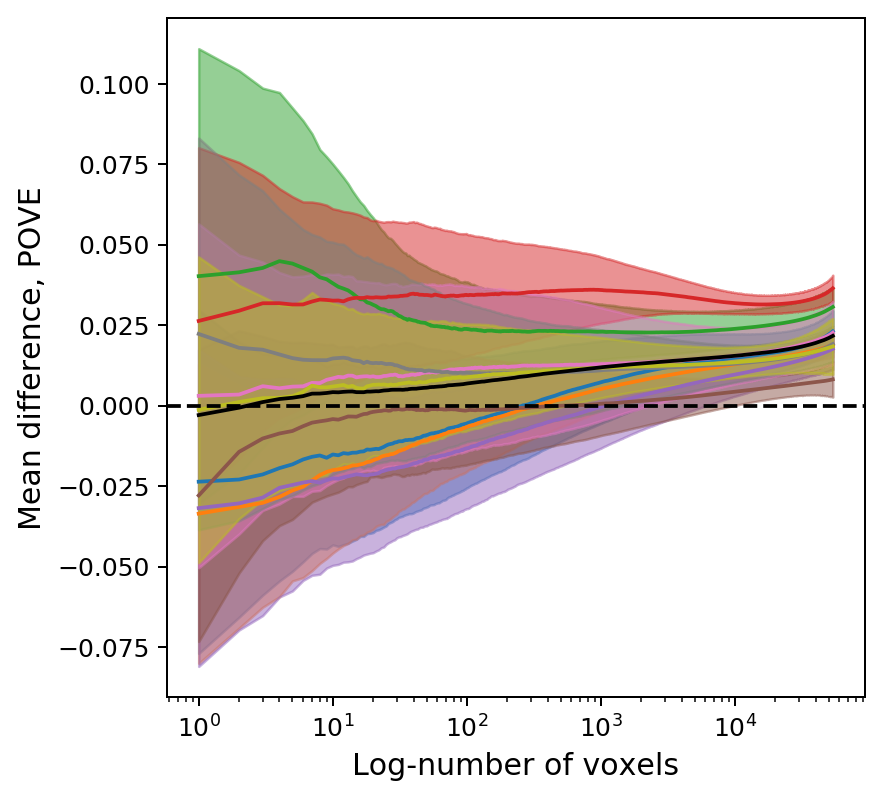

In [13]:
def plot_model_diff(ax, subjects, sorted_mean_diffs, sorted_std_diffs=None):    
    min_k = min(len(m) for m in sorted_mean_diffs)
    sorted_mean_diffs = [d[:min_k] for d in sorted_mean_diffs]
    if sorted_std_diffs is not None:
        sorted_std_diffs = [d[:min_k] for d in sorted_std_diffs]
    subj_mean = np.mean(sorted_mean_diffs, axis=0)
    for i in range(len(sorted_mean_diffs)):
        line_handler = ax.plot(
            np.arange(1, len(sorted_mean_diffs[i]) + 1), sorted_mean_diffs[i], label=subjects[i], zorder=2)[0]
        if sorted_std_diffs is not None:
            line_color = line_handler.get_color()
            ax.fill_between(
                np.arange(1, len(sorted_mean_diffs[i]) + 1), 
                sorted_mean_diffs[i] - sorted_std_diffs[i], 
                sorted_mean_diffs[i] + sorted_std_diffs[i], 
                color=line_color, alpha=0.5, zorder=1)
        
    ax.set_xscale('log')
    ax.set_xlabel('Log-number of voxels', size=12)
    # ax.set_ylabel('Mean difference, 20 vs. 20 accuracy', size=12)
    ax.set_ylabel('Mean difference, POVE', size=12)
    ax.axhline(0, color='black', linestyle='--')
    ax.plot(np.arange(1, len(subj_mean) + 1), subj_mean, color='black', label='Mean', zorder=2)
    # ax.legend()

fig = plt.figure(figsize=(5, 5), dpi=180)
ax = fig.add_subplot()
plot_model_diff(
    ax, 
    [r.subject for r in result], 
    [r.ab_sorted_diff_mean for r in result],
    [r.ab_sorted_diff_std for r in result])


In [14]:
variation_set_name_a = 'hp_meg_simple_fmri'
training_variation_a_fmt = '(\'hp_fmri_{subject}\',)'
variation_set_name_b = 'hp_HKL_from_I'
training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

# variation_set_name_a = 'hp_HKL_from_I'
# training_variation_a_fmt = '(\'hp_fmri_{subject}\',).hp_fmri_20:(\'hp_fmri_I\',)'
# variation_set_name_b = 'hp_HKL_from_I'
# training_variation_b_fmt = '(\'hp_fmri_{subject}\',)'

a = sentence_predictions(paths, variation_set_name_a, training_variation_a_fmt.format(subject='I'), 'hp_fmri_I')
b = sentence_predictions(paths, variation_set_name_b, training_variation_b_fmt.format(subject='I'), 'hp_fmri_I')

In [25]:
assert(len(a) == len(b))
token_list = list()
full_a_dist = list()
full_b_dist = list()
full_ab_dist = list()
for key in a:
    assert(len(a[key]) == len(b[key]))
    tokens = a[key][0].tokens
    a_dist = list()
    b_dist = list()
    ab_dist = list()
    for idx in range(len(a[key])):
        assert(np.array_equal(a[key][idx].target, b[key][idx].target))
        a_dist.append(np.sqrt(np.sum(np.square(a[key][idx].prediction - a[key][idx].target))))
        b_dist.append(np.sqrt(np.sum(np.square(b[key][idx].prediction - b[key][idx].target))))
        ab_dist.append(np.sqrt(np.sum(np.square(a[key][idx].prediction - b[key][idx].prediction))))
    full_a_dist.append(np.array(a_dist))
    full_b_dist.append(np.array(b_dist))
    full_ab_dist.append(np.array(ab_dist))
    token_list.append(tokens)
full_a_dist = np.array(full_a_dist)
full_b_dist = np.array(full_b_dist)
full_ab_dist = np.array(full_ab_dist)


In [5]:
ab_diff = np.mean(full_a_dist - full_b_dist, axis=1)
ab_distances = np.mean(full_ab_dist, axis=1)
indices_sorted = np.argsort(ab_diff)
is_positive = False
with open('scored_sentences.txt', 'wt') as f:
    for idx in indices_sorted:
        if not is_positive and ab_diff[idx] > 0:
            is_positive = True
            f.write('\n\n{}\n\n\n'.format(idx))
        f.write('{:9.7} {:9.7} {}\n'.format(ab_diff[idx], ab_distances[idx], ' '.join(token_list[idx])))

In [34]:
def read_clusters(paths, variation_set_name, training_variation, index_run, name):
    _, _, num_runs, _, aux_loss = named_variations(variation_set_name)
    if index_run >= num_runs:
        raise IndexError('Only {} runs exist: {}'.format(num_runs, index_run))
    training_variation = match_variation(variation_set_name, training_variation)
    model_dir = os.path.join(paths.model_path, variation_set_name, task_hash(training_variation))    
    cluster_id_path = os.path.join(model_dir, 'run_{}'.format(index_run), 'kmeans_clusters_{}.npy'.format(name))
    if not os.path.exists(cluster_id_path):
        raise ValueError('Path does not exist: {}'.format(cluster_id_path))
    return np.load(cluster_id_path)


fmri_subjects_ = ['F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
training_variation = tuple('hp_fmri_{}'.format(s) for s in fmri_subjects_)
        
cluster_ids = read_clusters(paths, 'hp_fmri_diff_cluster', training_variation, 0, 'hp_fmri_I')

def _indicator_cluster(include_ids):
    indicator_cluster = cluster_ids == include_ids[0]
    for c in include_ids[1:]:
        indicator_cluster = np.logical_or(indicator_cluster, cluster_ids == c)
    return indicator_cluster

clusters_of_interest = [79, 3, 98, 83, 81, 92, 49, 14, 65, 59, 48]
indicator_cluster = _indicator_cluster(clusters_of_interest)

# render_ids = np.full(cluster_ids.shape, np.nan)
# volume_dict = OrderedDict()

# for i in range(len(clusters_of_interest)):
#     indicator_cluster = _indicator_cluster([clusters_of_interest[i]])
#     render_ids[indicator_cluster] = i
#     volume_dict['I {}'.format(clusters_of_interest[i])] = make_volume(
#         np.where(indicator_cluster, 1, np.nan), 'I', cmap='Blues', vmin=0, vmax=1)

volume_dict = {'I all': make_volume(np.where(indicator_cluster, 1, np.nan), 'I', cmap='Blues', vmin=0, vmax=1)}

cortex.webshow(volume_dict, open_browser=False)


Started server on port 19029


<WebApp(Thread-9, started 139714933806848)>

Stopping server


In [25]:
def write_sentences_for_cluster(indicator_cluster):
    indicator_cluster = np.expand_dims(indicator_cluster, 0)
    assert(len(a) == len(b))
    token_list = list()
    full_a_dist = list()
    full_b_dist = list()
    full_ab_dist = list()
    for key in a:
        assert(len(a[key]) == len(b[key]))
        tokens = a[key][0].tokens
        a_dist = list()
        b_dist = list()
        ab_dist = list()
        for idx in range(len(a[key])):
            assert(np.array_equal(a[key][idx].target, b[key][idx].target))
            a_dist.append(np.sum(np.square(a[key][idx].prediction[indicator_cluster] - a[key][idx].target[indicator_cluster])))
            b_dist.append(np.sum(np.square(b[key][idx].prediction[indicator_cluster] - b[key][idx].target[indicator_cluster])))
            ab_dist.append(np.sum(np.square(a[key][idx].prediction[indicator_cluster] - b[key][idx].prediction[indicator_cluster])))
        full_a_dist.append(np.array(a_dist))
        full_b_dist.append(np.array(b_dist))
        full_ab_dist.append(np.array(ab_dist))
        token_list.append(tokens)
    full_a_dist = np.array(full_a_dist)
    full_b_dist = np.array(full_b_dist)
    full_ab_dist = np.array(full_ab_dist)

    ab_diff = np.mean(full_a_dist - full_b_dist, axis=1)
    ab_distances = np.mean(full_ab_dist, axis=1)
    indices_sorted = np.argsort(ab_diff)
    is_positive = False
    with open('scored_sentences_cluster.txt', 'wt') as f:
        for idx in indices_sorted:
            if not is_positive and ab_diff[idx] > 0:
                is_positive = True
                f.write('\n\n{}\n\n\n'.format(idx))
            f.write('{:9.7} {:9.7} {}\n'.format(ab_diff[idx], ab_distances[idx], ' '.join(token_list[idx])))

write_sentences_for_cluster(indicator_cluster)

In [17]:
def get_story_features(paths, variation_set_name, training_variation):
    
    from dataclasses import replace
    
    _, settings, _, _, _ = named_variations(variation_set_name)
    hp_corpus = settings.corpora[0]
    assert(hasattr(hp_corpus, 'story_features_per_fmri_example'))
    
    temp_paths = replace(
        paths, 
        model_path=os.path.join(paths.model_path, variation_set_name, task_hash(training_variation)),    
        result_path=os.path.join(paths.result_path, variation_set_name, task_hash(training_variation)))
    
    return hp_corpus.story_features_per_fmri_example(temp_paths)

story_features = get_story_features(paths, 'hp_meg_simple_fmri', '(\'hp_fmri_I\',)')

In [ ]:
def bar_chart(
    ax, a, b, label_a, label_b, color_a='blue', color_b='red', title=None, skip_zero_counts=True, relative=False):
    
    width = 0.25       # the width of the bars
    
    assert(len(a) == len(b))
    labels = list()
    a_values = list()
    a_std = list()
    b_values = list()
    b_std = list()
    for label in sorted(a):
        if skip_zero_counts and (label not in a or a[label] == 0) and (label not in b or b[label] == 0):
            continue
        labels.append(label)
        if label in a:
            m, s = a[label]
        else:
            m, s = 0, 0
        a_values.append(m)
        a_std.append(s)
        if label in b:
            m, s = b[label]
        else:
            m, s = 0, 0
        b_values.append(m)
        b_std.append(s)
        
    ind = np.arange(len(labels)) + 1  # the x locations for the groups, shift up by 1 to create a margin
    
    a_values = np.array(a_values)
    b_values = np.array(b_values)
    a_std = np.array(a_std)
    b_std = np.array(b_std)
    
    if relative:
        max_ab = np.maximum(a_values, b_values)
        a_values = a_values / max_ab
        b_values = b_values / max_ab
        a_std = a_std / max_ab
        b_std = b_std / max_ab
    
    a_bars = ax.barh(ind, a_values, width, color=color_a, xerr=a_std)
    b_bars = ax.barh(ind + width, b_values, width, color=color_b, xerr=b_std)

    # add some text for labels, title and axes ticks
    ax.set_xlabel('Feature probability')
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title('Feature distributions')
    ax.set_yticks(ind + width / 2)
    ax.set_yticklabels(labels)
    ax.set_xlim(0, ax.get_xlim()[1])
    ax.set_ylim(0, len(a_values) + 1 + width)
    
    ax.legend((a_bars[0], b_bars[0]), (label_a, label_b))

    
def _eucl(x, y=None, norm=False):
    if y is None:
        return np.sqrt(np.sum(np.square(x)))
    diff = np.sqrt(np.sum(np.square(x - y)))
    if norm:
        return diff / np.sqrt(np.sum(np.square(y)))
    return diff
    

def histogram_for_cluster(indicator_cluster):
    indicator_cluster = np.expand_dims(indicator_cluster, 0)
    assert(len(a) == len(b))
    token_list = list()
    full_a_dist = list()
    full_b_dist = list()
    for key in a:  # key is the unique_id
        assert(len(a[key]) == len(b[key]))
        tokens = a[key][0].tokens
        a_dist = list()
        b_dist = list()
        for idx in range(len(a[key])):  # idx because there are multiple runs/predictions for each unique_id
            assert(np.array_equal(a[key][idx].target, b[key][idx].target))
            a_dist.append(
                _eucl(a[key][idx].prediction[indicator_cluster], a[key][idx].target[indicator_cluster], norm=True))
            b_dist.append(
                _eucl(b[key][idx].prediction[indicator_cluster], b[key][idx].target[indicator_cluster], norm=True))
        full_a_dist.append(np.array(a_dist))
        full_b_dist.append(np.array(b_dist))
        token_list.append(tokens)
    full_a_dist = np.array(full_a_dist)
    full_b_dist = np.array(full_b_dist)
    
    ab_diff = np.mean((full_a_dist - full_b_dist) / full_b_dist, axis=1)
    indices_sorted = np.argsort(np.abs(ab_diff))
    ab_diff = ab_diff[indices_sorted]
    
    index_cutoff = np.flatnonzero(ab_diff >= .1)[0]
    print(index_cutoff, len(ab_diff) - index_cutoff)
    
    keys = list(a.keys())
    keys = list(keys[indices_sorted[i]] for i in range(len(indices_sorted)))
    keys = np.array(keys)
    
    def _get_features(unique_ids):
        f = dict()
        total = 0
        for u in unique_ids:
            sticky_counts = dict()
            total += len(story_features[u])
            for w in story_features[u]:
                for k in w.story_features:
                    if isinstance(k, tuple) and k[0] == 'NNSE':
                        continue
                    if k in ['RNNhidden', 'RNNemb', 'RNNprob', 'dependency', 'word_form']:
                        continue
                    if isinstance(k, tuple) and k[1].endswith('_sticky'):
                        continue
                    if not isinstance(k, tuple):
                        continue
                    if k[0].lower() not in ['part_of_speech', 'motion', 'emotion']:
                        continue
                    if k not in f:
                        f[k] = w.story_features[k].astype(int)
                    else:
                        f[k] += w.story_features[k].astype(int)
        for k in f:
            f[k] /= total
        return f
    
    def _bootstrap_features(unique_ids, num_samples=100):
        all_samples = dict()
        for idx_sample in range(num_samples):
            sample_indices = np.random.choice(len(unique_ids), size=len(unique_ids), replace=True)
            sampled_ids = unique_ids[sample_indices]
            f = _get_features(sampled_ids)
            for k in f:
                if k not in all_samples:
                    all_samples[k] = [f[k]]
                else:
                    all_samples[k].append(f[k])
        for k in all_samples:
            if len(all_samples[k]) < num_samples:
                all_samples[k] = all_samples[k] + [0] * (num_samples - len(all_samples[k]))
            all_samples[k] = (np.mean(all_samples[k]), np.std(all_samples[k]))
        return all_samples
    
    def _split_features(f):
        split_features = OrderedDict()
        for k in f:
            split_k = k[0] if isinstance(k, tuple) else '__string__'
            if split_k not in split_features:
                split_features[split_k] = dict()
            split_features[split_k][k[1] if isinstance(k, tuple) else k] = f[k]
        return split_features
        
    
    least_changed_features = _bootstrap_features(keys[:index_cutoff])
    most_changed_features = _bootstrap_features(keys[index_cutoff:])
    
    separate_least = _split_features(least_changed_features)
    separate_most = _split_features(most_changed_features)
    
    for k in separate_most:
        fig = plt.figure(figsize=(10, (len(separate_most[k]) + 3) * 0.5), dpi=180)
        ax = fig.add_subplot()
        bar_chart(
            ax, separate_most[k], separate_least[k], 
            'most changed', 'least changed', color_a='teal', color_b='tomato',
            title='{} feature distributions'.format(' '.join(k.split('_'))) if k != '__string__' else None, 
            relative=False)
        plt.show()
        
histogram_for_cluster(indicator_cluster)


1022 146
